 # Cocco, Gomes, & Maenhout (2005)

 # "[Consumption and Portfolio Choice Over the Life Cycle](https://academic.oup.com/rfs/article-abstract/18/2/491/1599892)"

 - Notebook created by Mateo Velásquez-Giraldo and Matthew Zahn.

 This notebook uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to describe the main results and reproduce the figures in the linked paper. The main HARK tool used here is the $\texttt{PortfolioConsumerType}$ class. For an introduction to this module, see the [ConsPortfolioModelDoc.ipynb](https://github.com/econ-ark/DemARK/blob/master/notebooks/ConsPortfolioModelDoc.ipynb) notebook.

 __NOTES:__ This is a _preliminary draft_. Work is ongoing to refine the replicaition code and improve its presentation in this context. Original results from the paper act as placeholders for ongoing replications.

In [1]:
# This cell does some preliminary set up

# Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import relevenat HARK tools
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm

### The base model

The authors' aim is to represent the life cycle of a consumer that is exposed to uninsurable labor income risk and how he chooses to allocate his savings between a risky and a safe asset, without the possibility to borrow or short-sell.

##### Dynamic problem

The problem of an agent $i$ of age $t$ in the base model is recursively represented as

\begin{split}
V_{i,t} =& \max_{0\leq C_{i,t} \leq X_{i,t}, \alpha_{i,t}\in[0,1]} U(C_{i,t}) + \delta p_t E_t\{ V_{i,t+1} (X_{i,t+1}) \}\\
&\text{s.t}\\
&X_{i,t+1} = Y_{i,t+1} + (X_{i,t} - C_{i,t})(\alpha_{i,t} R_{t+1} + (1-\alpha_{i,t})\bar{R}_f)
\end{split}

where $C_{i,t}$ is consumption, $\alpha_{i,t}$ is the share of savings allocated to the risky asset, $Y_{i,t}$ is labor income, and $X_{i,t}$ represents wealth. The utility function $U(\cdot)$ is assumed to be CRRA in the base model. Extensions beyond the baseline model include an additively separable bequest motive in the utility function. The discount factor is $\delta$ and $p_t$ is the probability of survival from $t$ to $t+1$. Death is certain at a maximum period $T$.

Note that the consumer cannot borrow or short-sell.

The control variables in the problem are $\{C_{it}, \alpha_{it}\}^T_{t=1}$ and the state variables are $\{t, X_{it}, v_{it} \}^T_{t=1}$. The agent solves for  policy rules as a function of the state variables&mdash;$C_{it}(X_{it}, v_{it})$ and $\alpha_{it}(X_{it}, v_{it})$.

#### Labor income

An important driver of the paper's results is the labor income process. It is specified as follows:

\begin{equation}
\log Y_{i,t} = f(t,Z_{i,t}) + v_{i,t} + \epsilon_{i,t}, \quad \text{for } t\leq K.
\end{equation}

where $K$ is the (exogenous) age of retirement, $Z_{i,t}$ are demographic characteristics, $\epsilon_{i,t}\sim \mathcal{N}(0,\sigma^2_\epsilon)$ is a transitory shock, and  $v_{i,t}$ is a permanent component following a random walk

\begin{equation}
v_{i,t} = v_{i,t-1} + u_{i,t} = v_{i,t-1} + \xi_t + \omega_{i,t}
\end{equation}

in which the innovation is decomposed into an aggregate ($\xi_t$) and an idiosyncratic component ($\omega_{i,t}$), both following mean-0 normal distributions.

Post-retirement income is a constant fraction $\lambda$ of permanent income in the last working year $K$.

A crucial aspect of the labor income process is that $f(\cdot,\cdot)$ is calibrated to match income profiles in the PSID, capturing the usual humped shape of income across lifetime.

#### Matching labor income in HARK

In HARK's consumption-saving models, the income process takes the form
\begin{equation}
    \ln Y_t = \ln P_t + \ln \theta_t
\end{equation}
where $P_t$ represents permanent income and $\ln \theta_t \sim N(0,\sigma_\theta)$ transitory shocks to income. Permanent income evolves according to
\begin{equation}
    \ln P_{t+1} = \ln \Gamma_{t+1} +  \ln \psi_{t+1} + \ln P_t
\end{equation}
where $\Gamma_{t+1}$ is a deterministic growth factor, and $\ln \psi_{t+1} \sim N(0,\sigma_\psi)$ a permanent income shock. 


To represent the author's assumptions in HARK, we express both income processes as sums of deterministic components and i.i.d shocks
\begin{align}
\text{Cocco et. al} &\quad& \ln Y_{i,t} &=& f(t,Z_{i,t}) + v_{i,0} &+&\sum_{k=1}^t u_{i,k} &+&\qquad \varepsilon_{i,t} \\
\text{HARK}        &\quad& \ln Y_{i,t} &=& \ln P_{i,0} + \sum_{k=1}^t \ln \Gamma_k &+&\sum_{k=1}^t \ln \psi_{i,k} &+& \qquad \ln \theta_{i,t}.
\end{align}

These representations make evident the mapping that we use

|HARK | Cocco et. al |
| :---: | :-----------: |
| $P_{i,0}$ | $f(0,Z_{i,0})$ + $v_{i,0}$ |
| $\ln$ $\Gamma_{t+1}$| $f(t+1$, $Z_{i,t+1})$ - $f(t,Z_{i,t})$|
|$\ln$ $\psi_{i,k}$| $u_{i,k}$|
|$\ln$ $\theta_{i,t}$| $\varepsilon_{i,t}$|

and to achieve a retirement income that is equal to a fraction $\lambda$ of permanent income in the last working period $K$, we simply make $\Gamma_{K+1} = \lambda$ and $\Gamma_{t} = 1$ $\forall t>K+1$.

#### Assets and their returns

There are two assets available for consumers to allocate their savings.

- Bonds: paying a risk-free return $\bar{R}_f$.

- Stocks: paying a stochastic return $R_t = \bar{R}_f + \mu + \eta_t$, where the stochastic component $\eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$ is allowed to be correlated with the aggregate labor income innovation $\xi_t$.

The borrowing and short-selling constraints ensure that agents cannot allocate negative dollars to either of these assets or borrow against future labor income or retirement wealth. Recall $\alpha_{i,t}$ is the proportion of the investor's savings that are invested in the risky asset. The model's constraints imply that $\alpha_{i,t}\in[0,1]$ and wealth is non-negative.


### Calibration&mdash;Summary

The paper defines and calibrates several parameters which can be broken down into the following categories:

__1. Preferences and life cycle__

 | Parameter | Description | Code | Value |
 |:---:| ---         | ---  | :---: |
 | $\delta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
 | $\gamma$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 10 |
 | $p_t$ | Survival Propility | $\texttt{LivPrb}$ | [0.6809,0.99845] |
 | $t_0$ | Starting Age | $\texttt{t_start}$ | 20 |
 | $t_r$ | Retirement Age | $\texttt{t_ret}$ | 65 |
 | $T$ | Maximum Age | $\texttt{t_end}$ | 100 |

__2. Income process and the finanical assets__

 | Parameter | Description | Code | Value|
 |:---:| ---         | ---  | :---: |
 | $f(t,Z_{i,t})$| Average income at each stage of life | $\texttt{det_income}$ | $ \exp($0.530339 + 0.16818 $t$+ (0.0323371/10) $t^2$ + (0.0019704/100) $t^3)$ |
 | $\lambda$ | Last Period Labor Income Share for Retirement | $\texttt{repl_fac}$ | 0.68212 |
 | $\log \Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | $\{\log f_{t+1} - \log f_t\}^{t_r+1}_{t=20}$ |
 | $\mathsf{R}$ | Interest Factor | $\texttt{Rfree}$ | 1.02 |
 | $\mu$ | Average Stock Return | $\texttt{RiskyDstnFunc}$ \& $\texttt{RiskyDrawFunc}$ | 1.06 |
 | $\sigma_\eta$ | Std Dev of Stock Returns | $\texttt{RiskyDstnFunc}$ \& $\texttt{RiskyDrawFunc}$ | 0.157 |


__3. Shocks__

 | Parameter | Description | Code | Value |
 |:---:| ---         | ---  | :---: |
 | $\sigma_v$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.102956 |
 | $\sigma_\epsilon$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.27166 |


For reference, the authors' source Fortran code that includes these paramerization details is available on [Gomes' personal page](http://faculty.london.edu/fgomes/research.html). Code that solves the model is also available in [Julia](https://github.com/econ-ark/HARK/issues/114#issuecomment-371891418).

In [2]:
# Calibrate the model in line with the information above
import sys,os
sys.path.append(os.path.realpath('../Code/Calibration')) # [[Explain what this does. Navigate to folder. What the script does.]]
from params import dict_portfolio, time_params, det_income

In [3]:
# Solve the model with the given parameters
agent = cpm.PortfolioConsumerType(**dict_portfolio)
agent.solve()

### Key Results

#### The optimal risky asset share

The plot below shows the policy function for the risky portfolio share as a function of wealth at different ages.

The optimal risky share is decreasing in wealth. The authors argue this is due to the fact that, at low levels of wealth, relatively safe human wealth represents a higher fraction of the consumer's wealth, so he shifts his tradeable wealth towards riskier alternatives.

Analyzing the policy rule by age also shows that the risky share increases from young to middle age, and decreases from middle to old age. This is consistent with the previous interpretation: shares trace the humped shape of labor earnings.

__[[Discuss how close these are to the paper and discuss differences.]]__

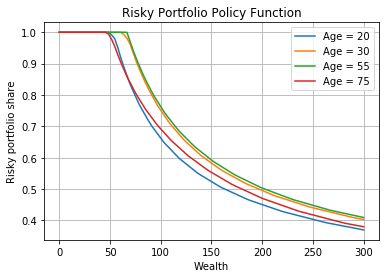

In [4]:
# Plot portfolio rule
eevalgrid = np.linspace(0,300,100)
plt.figure()
# In the last period of life you consume everything
# so portfolio choice is irrelevant

# Ages
ages = [20,30,55,75]
age_born = time_params['Age_born']
for a in ages:
    plt.plot(eevalgrid,
             agent.solution[a-age_born].RiskyShareFunc[0][0](eevalgrid/det_income[a-age_born]),
             label = 'Age = %i' %(a))
plt.xlabel('Wealth')
plt.ylabel('Risky portfolio share')
plt.title('Risky Portfolio Policy Function')
plt.legend()
plt.grid()

#### Consumption behavior

The plot below shows the policy function for consumption as a function of wealth at different ages.

At all age levels consumption increases with wealth. In the first phase of life (until approximately 35 to 40) the consumption function shifts upward as the agent ages, driven by permanent income increases. As the agent gets closer to retirement, their labor income profile becomes negatively sloped causing declines in consumption at some wealth levels.

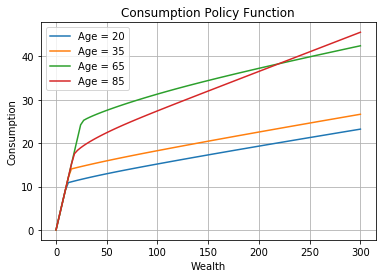

In [5]:
# Plot consumption function
plt.figure()
ages = [20,35,65,85]
for a in ages:
    plt.plot(eevalgrid,
             agent.solution[a-age_born].cFunc[0][0](eevalgrid/det_income[a-age_born])*det_income[a-age_born],
             label = 'Age = %i' %(a))
plt.xlabel('Wealth')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
plt.legend()
plt.grid()

### Simulations

Using the policy functions obtained from solving the model we present a series of simulations to highlight features of the model.

The figures below show simulated levels of permanent income and risky portfolio shares for 100 agents over their life spans. We can see the model generates a heterogeneous permanent income distribution. Interestingly, all of these agents tend to follow the same general pattern for investing in the risky asset. Early in life, all of their portfolios are invested in the risky asset. This declines as the agent ages and converges to approximately 20% once they reach retirement.

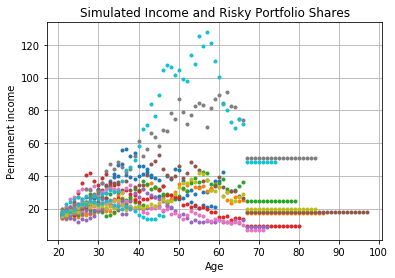

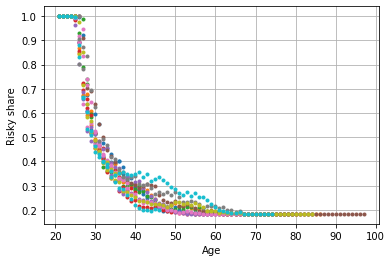

In [6]:
agent.track_vars = ['aNrmNow','cNrmNow', 'pLvlNow', 't_age', 'RiskyShareNow','mNrmNow']
agent.initializeSim()
agent.simulate()

plt.figure()
plt.plot(agent.t_age_hist+time_params['Age_born'], agent.pLvlNow_hist,'.')
plt.xlabel('Age')
plt.ylabel('Permanent income')
plt.title('Simulated Income and Risky Portfolio Shares')
plt.grid()

plt.figure()
plt.plot(agent.t_age_hist+time_params['Age_born'], agent.RiskyShareNow_hist,'.')
plt.xlabel('Age')
plt.ylabel('Risky share')
plt.grid()

The plot below illustrates the average dynamics of permanent income, consumption, and market resources across all of the simulated agents. __[[Agents appear to be earning too much market resources at the moment. Place holder for updated results and discussion based on updates to HARK toolkit.]]__

In [7]:
raw_data = {'Age': agent.t_age_hist.flatten()+time_params['Age_born'],
            'pIncome': agent.pLvlNow_hist.flatten(),
            'rShare': agent.RiskyShareNow_hist.flatten(),
            'nrmM': agent.mNrmNow_hist.flatten(),
            'nrmC': agent.cNrmNow_hist.flatten()}

Data = pd.DataFrame(raw_data)
Data['Cons'] = Data.nrmC * Data.pIncome
Data['M'] = Data.nrmM * Data.pIncome

# Find the mean of each variable at every age
AgeMeans = Data.groupby(['Age']).mean().reset_index()

Text(0, 0.5, 'Risky Share')

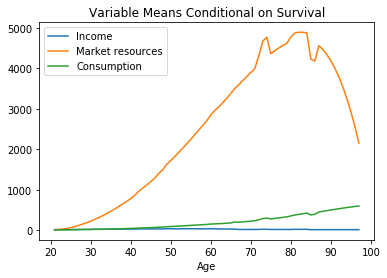

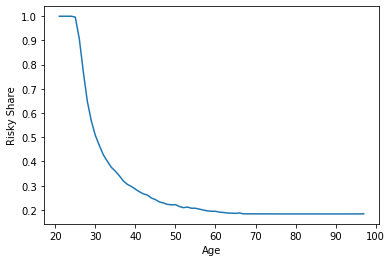

In [8]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome,
         label = 'Income')
plt.plot(AgeMeans.Age, AgeMeans.M,
         label = 'Market resources')
plt.plot(AgeMeans.Age, AgeMeans.Cons,
         label = 'Consumption')
plt.legend()
plt.xlabel('Age')
plt.title('Variable Means Conditional on Survival')

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.rShare)
plt.xlabel('Age')
plt.ylabel('Risky Share')

The plot below illustrates the dynamics of permanent income, consumption, and market resources for a single agent. This plot highlights some unusual consumption dynamics as well as the beginning of sharp increase in market resources.

Text(0.5, 0, 'Age')

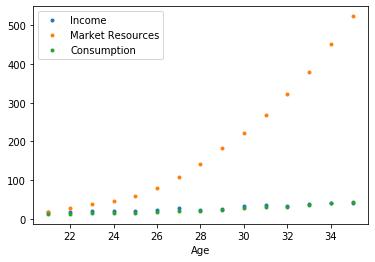

In [9]:
ind = 0
age = agent.t_age_hist[0:15,ind]+age_born
p = agent.pLvlNow_hist[0:15,ind]
c = agent.cNrmNow_hist[0:15,ind]
m = agent.mNrmNow_hist[0:15,ind]

plt.figure()
plt.plot(age,p,'.',label = 'Income')
plt.plot(age,m*p,'.', label = 'Market Resources')
plt.plot(age,c*p,'.', label = 'Consumption')
plt.legend()
plt.xlabel('Age')

#### The welfare implications of different allocation rules

The authors next conduct a welfare analysis of different allocation rules, including popular heuristics. The rules are presented in the next figure.

<center><img src="Figures\Alloc_rules.jpg" style="height:500px"></center>

The utility cost of each policy in terms of constant consumption streams with respect to the authors calculated optimal policy function is reported in the next table.

<center><img src="Figures\Util_cost.jpg" style="height:100px"></center>

Interestingly, the "no-income" column corresponds to the usual portfolio choice result of the optimal share being the quotient of excess returns and risk times relative risk aversion, disregarding labor income. The experiment shows this allocation produces substantial welfare losses.

#### Heterogeneity and sensitivity analysis

The authors also considered a number of extensions to the baseline model. These are summaried below along with their main conclusions.

- Labor income risk: Income risk may vary across employment sectors relative to the baseline model. The authors examine extreme cases for industries that have a large standard deviation and temporary income shocks. While some differences appear across sectors, the results are generally in line with the baseline model.
- Disastrous labor income shocks: The authors find that even a small probability of zero labor income lowers the optimal portfolio allocation in stocks, while the qualitative features of the baseline model are preserved.
- Uncertain retirement income: The authors consider two types of uncertainty for retirement income; it is stochastic and correlated with current stock market performance and allowing for disastrous labor income draws before retirement. The first extension has results essentially the same as the baseline case. The second leads to more conservative portfolio allocations but is broadly consistent with the baseline model.
- Endogenous borrowing constraints: The authors add borrowing to their model by building on credit-market imperfections. They find that the average investor borrows about \$5,000 and are in debt for most of their working life. The agents eventually pay off this debt and save for retirement. Relative to the benchmark model, the investor has put less of their money in their portfolio and arrive at retirement with substantially less wealth. These results are particularly pronounced at the lower end of the income distribution relative to the higher end. Additional details are available in the text.
- Bequest motive: The authors introduce a bequest motive into the agent's utility function (i.e., $b>0$). Young investors are more impatient and tend to save less for bequests. As the agent ages, savings increases and is strongest once the agent retires. This leads to effects on the agent's portfolio allocation. Taking a step-back however, these effects are not very large unless $b$ is large.
- Educational attainment: The authors generally find that savings are consistent across education groups. They note that for a given age, the importance of future income is increasing with education level. This implies that riskless asset holdings are larger for these households.
- Risk aversion and intertemporal substitution: Lowering the level of risk aversion in the model leads to changes in the optimal portfolio allocation and wealth accumulation. Less risk-averse investors accumulate less precautionary savings and invest more in risky assets.

### Conclusion

This article provides a dynamic model with accurate lifetime income profiles in which labor income increases risky asset holdings, as it is seen as a closer substitute of risk-free assets. It finds an optimal risky asset share that decreases in wealth and with age, after middle age. The model is also used to show that ignoring labor income for portfolio allocation can generate substantial welfare losses.

### Puzzles/ Questions

- Table 4 says stock returns are $0.06$. They might mean that the equity premium $\mu$ is $0.06$.


In [10]:
### Bibtex entry
'''
@article{10.1093/rfs/hhi017,
    author = {Cocco, João F. and Gomes, Francisco J. and Maenhout, Pascal J.},
    title = "{Consumption and Portfolio Choice over the Life Cycle}",
    journal = {The Review of Financial Studies},
    volume = {18},
    number = {2},
    pages = {491-533},
    year = {2005},
    month = {02},
    abstract = "{This article solves a realistically calibrated life cycle model of consumption and portfolio choice with non-tradable labor income and borrowing constraints. Since labor income substitutes for riskless asset holdings, the optimal share invested in equities is roughly decreasing over life. We compute a measure of the importance of human capital for investment behavior. We find that ignoring labor income generates large utility costs, while the cost of ignoring only its risk is an order of magnitude smaller, except when we allow for a disastrous labor income shock. Moreover, we study the implications of introducing endogenous borrowing constraints in this incomplete-markets setting.}",
    issn = {0893-9454},
    doi = {10.1093/rfs/hhi017},
    url = {https://doi.org/10.1093/rfs/hhi017},
    eprint = {http://oup.prod.sis.lan/rfs/article-pdf/18/2/491/24421441/hhi017.pdf},
}
'''

'\n@article{10.1093/rfs/hhi017,\n    author = {Cocco, João F. and Gomes, Francisco J. and Maenhout, Pascal J.},\n    title = "{Consumption and Portfolio Choice over the Life Cycle}",\n    journal = {The Review of Financial Studies},\n    volume = {18},\n    number = {2},\n    pages = {491-533},\n    year = {2005},\n    month = {02},\n    abstract = "{This article solves a realistically calibrated life cycle model of consumption and portfolio choice with non-tradable labor income and borrowing constraints. Since labor income substitutes for riskless asset holdings, the optimal share invested in equities is roughly decreasing over life. We compute a measure of the importance of human capital for investment behavior. We find that ignoring labor income generates large utility costs, while the cost of ignoring only its risk is an order of magnitude smaller, except when we allow for a disastrous labor income shock. Moreover, we study the implications of introducing endogenous borrowing const